# Setup 
Initial Library

In [14]:
# Basic libraries
import xarray as xr
import rioxarray
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# for Stac
import pystac_client
import dask 
from dask_gateway import Gateway

# transformation
from pyproj import Transformer

# warning
import warnings

Accessing the Cluster

In [2]:
gate = Gateway()
cluster = gate.new_cluster()
cluster.scale(8)

In [3]:
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://dask.user.eopf.eodc.eu/clusters/binderhub.a66cffe7dbd1452cb8ed3926acf7f2c5/status,


# Data Accessing

Small Visualization of AOI

In [4]:
import folium

bbox = (11.290770,46.356466,11.315060,46.389037)
min_lon, min_lat, max_lon, max_lat = bbox
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
folium.Polygon(
    [
        [min_lat, min_lon],
        [min_lat, max_lon],
        [max_lat, max_lon],
        [max_lat, min_lon],
    ],
    color="red",
    weight=3,
    fill=False
).add_to(m)
m


Accessing Data, 
Here we querythe EOPF Sentinel-2 STAC for our area and time of interest.

In [5]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
bbox = [
    11.290770,46.356466,11.315060,46.389037,
]
raw_items = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=["2019-12-31", "2024-01-01"],
)
items = list(raw_items.items_as_dicts())
base_paths = []
for item in items:
    href = item['assets']['SR_10m']['href']
    base_path = href.split('/measurements')[0]
    base_paths.append(base_path)
print(f"Total items: {len(base_paths)}")

Total items: 545


Forming Datacube

In [6]:
%%time
# reprojecting the CRS to the data set one
def reproject_bbox(bbox, src_crs="EPSG:4326", dst_crs="EPSG:32632"):
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    xmin, ymin = transformer.transform(bbox[0], bbox[1])
    xmax, ymax = transformer.transform(bbox[2], bbox[3])
    return [xmin, ymin, xmax, ymax]

# Specifing the bands
def load_tile(item_dict, bbox_ll):
    # Base path extractionm
    href = item_dict['assets']['SR_10m']['href']
    base_path = href.split('/measurements')[0]
    ds = xr.open_datatree(base_path, engine="zarr", chunks={}, mask_and_scale=True)
    
    #taking crs of the dataset
    dst_crs = item_dict['properties'].get("proj:code", "EPSG:32632")
    utm_bbox = reproject_bbox(bbox_ll, dst_crs=dst_crs)
    
    # Loading 10m resolution bands (B02, B03, B04, B08)
    ds_ref = (
        ds["measurements"]["reflectance"]["r10m"]
        .to_dataset()[["b02", "b03", "b04", "b08"]]
        .sel(x=slice(utm_bbox[0], utm_bbox[2]), y=slice(utm_bbox[3], utm_bbox[1]))
        .expand_dims(time=[item_dict['properties']['datetime']])
    )
    """
    # Load SCL(Scene Classification Layer) mask at 20m resolution, 
    # but there is a problem with the overlap
    ds_scl = (
        ds["conditions"]["mask"]["l2a_classification"]["r20m"]
        .to_dataset()
        .sel(x=slice(utm_bbox[0], utm_bbox[2]), y=slice(utm_bbox[3], utm_bbox[1]))
        .expand_dims(time=[item_dict['properties']['datetime']])
    )
    """

    # so we merge only one
    return xr.merge([ds_ref])

delayed_results = [dask.delayed(load_tile)(item, bbox) for item in items]
results = dask.compute(*delayed_results)

# Get CRS from first STAC item
crs = items[0]['properties'].get("proj:code", "EPSG:32632")
datacube = xr.concat(results, dim="time").sortby("time")
datacube = datacube.rio.write_crs(crs, inplace=True)
datacube

CPU times: user 6.72 s, sys: 556 ms, total: 7.28 s
Wall time: 1min 10s


<xarray.Dataset> Size: 1GB
Dimensions:      (time: 545, y: 368, x: 177)
Coordinates:
  * time         (time) object 4kB '2020-01-02T10:24:21.024000Z' ... '2023-12...
  * x            (x) float32 708B 6.762e+05 6.762e+05 ... 6.78e+05 6.78e+05
  * y            (y) float32 1kB 5.14e+06 5.14e+06 ... 5.136e+06 5.136e+06
    spatial_ref  int64 8B 0
Data variables:
    b02          (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b03          (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b04          (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b08          (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>

Datacube info

In [26]:
print("First date:",datacube.time.values[0], "\nLast date:",datacube.time.values[-1],"\nTotal 4 years")
datacube.info()

First date: 2020-01-02T10:24:21.024000Z 
Last date: 2023-12-29T10:14:31.024000Z 
Total 4 years
xarray.Dataset {
dimensions:
	time = 545 ;
	y = 368 ;
	x = 177 ;

variables:
	float64 b02(time, y, x) ;
		b02:_eopf_attrs = {'add_offset': -0.1, 'coordinates': ['y', 'x'], 'dimensions': ['y', 'x'], 'dtype': '<u2', 'eopf_is_masked': True, 'eopf_is_scaled': True, 'eopf_target_dtype': '<f8', 'fill_value': 0, 'long_name': 'BOA reflectance from MSI acquisition at spectral band 02 490 nm', 'scale_factor': 0.0001, 'short_name': 'b02_10m', 'units': 'digital_counts', 'valid_max': 65535, 'valid_min': 1} ;
		b02:dtype = <u2 ;
		b02:long_name = BOA reflectance from MSI acquisition at spectral band 02 490 nm ;
		b02:units = digital_counts ;
	float64 b03(time, y, x) ;
		b03:_eopf_attrs = {'add_offset': -0.1, 'coordinates': ['y', 'x'], 'dimensions': ['y', 'x'], 'dtype': '<u2', 'eopf_is_masked': True, 'eopf_is_scaled': True, 'eopf_target_dtype': '<f8', 'fill_value': 0, 'long_name': 'BOA reflectance from MSI 

Visualizing the extracted data from the cube

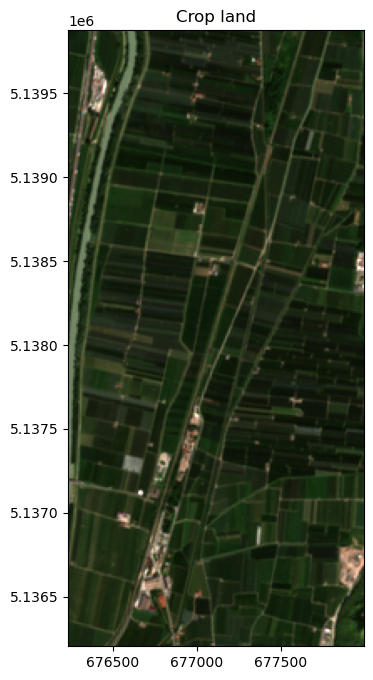

In [16]:
# Taking the 100 tile
rgb = datacube.isel(time=100)[["b04", "b03", "b02"]]

# nromalizing here
vmin, vmax = 0, 0.25 
rgb_norm = ((rgb - vmin) / (vmax - vmin)).clip(0, 1)

# transposing
img = rgb_norm.to_array().transpose("y", "x", "variable").values

plt.figure(figsize=(8, 8))
plt.imshow(
    img,
    extent=[
        rgb.x.values.min(),
        rgb.x.values.max(),
        rgb.y.values.min(),
        rgb.y.values.max(),
    ],
)
plt.title("Crop land")
plt.show()

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)